In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import math
import requests
from bs4 import BeautifulSoup
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn import metrics
pd.set_option("display.max_columns",100)

from helper_functions.functions import Helpers
from joblib import dump
from joblib import load

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

grounds = np.load('grounds.npy')
grounds = np.append(grounds, 'other')
enc.fit(pd.DataFrame(grounds))
# dump(enc, 'models/enc.joblib') 

OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>)

In [4]:
enc = load('models/enc.joblib')

In [18]:
## Proxy settings when using cntlm
http_proxy  = "http://localhost:3128"
https_proxy = "https://localhost:3128"

proxyDict = { 
              "http"  : http_proxy, 
              "https" : https_proxy, 
            }
proxyDict = None

In [19]:
mapping = {
    'Richmond': 'richmond',
    'West Coast': 'westcoast',
    'Sydney': 'swans',
    'Adelaide': 'adelaide',
    'Geelong': 'geelong',
    'Greater Western Sydney': 'gws',
    'Melbourne': 'melbourne',
    'Port Adelaide': 'padelaide',
    'Collingwood': 'collingwood',
    'Hawthorn': 'hawthorn',
    'Essendon': 'essendon',
    'Western Bulldogs': 'bullldogs',
    'St Kilda': 'stkilda',
    'North Melbourne': 'kangaroos',
    'Kangaroos' : 'kangaroos',
    'Fremantle': 'fremantle',
    'Brisbane Lions': 'brisbanel',
    'Gold Coast': 'goldcoast',
    'Carlton': 'carlton'
}
teams = list(mapping.keys())

In [21]:
from data_prep.team_history import History
# team_df = History(mapping, proxyDict, enc).generate_team_history(season_list=range(16))
team_df = History(mapping, proxyDict, enc).generate_team_history(season_list=[0]) # current season

Richmond 0
West Coast 0
Sydney 0
Adelaide 0
Geelong 0
Greater Western Sydney 0
Melbourne 0
Port Adelaide 0
Collingwood 0
Hawthorn 0
Essendon 0
Western Bulldogs 0
St Kilda 0
North Melbourne 0
Fremantle 0
Brisbane Lions 0
Gold Coast 0
Carlton 0


In [22]:
from data_prep.team_history import History
# History(mapping, proxyDict, enc).generate_game_data('training-all/', team_df,season_list=range(16))
History(mapping, proxyDict, enc).generate_game_data('training-all/', team_df, season_list=[0]) # current season

2019 Richmond
2019 West Coast
2019 Sydney
2019 Adelaide
2019 Geelong
2019 Greater Western Sydney
2019 Melbourne
2019 Port Adelaide
2019 Collingwood
2019 Hawthorn
2019 Essendon
2019 Western Bulldogs
2019 St Kilda
2019 North Melbourne
2019 Fremantle
2019 Brisbane Lions
2019 Gold Coast
2019 Carlton


In [106]:
X_list = []
y_list = []
rnd = 1 #Filter out rounds before this number

## Easy seasons 11, 12, 13, 16 [8,7,6,3]. Remove to build conservative models
cons = [] #[8,7,6,3]
if cons:
    seasons = [i for i in range(12) if i not in cons]
else:
    seasons = range(12)

for i in seasons:
    X = np.load('training-all/training-'+str(2019-i)+'.npy')

    mask = np.isnan(X).any(axis=1)
    index = np.where(mask==True)[0][0] ## X8 has a row containing nulls
    X = np.delete(X, index, 0)
    mask2 = np.array([(row[0] >= rnd) for row in X])
    X_list.append(X[mask2])

    y = np.load('training-all/results-'+str(2019-i)+'.npy')
    y = np.delete(y, index, 0)
    y_list.append(y[mask2])
    
X = np.concatenate(X_list, axis=0)
y = np.concatenate(y_list, axis=0)

print(X.shape)
print(y.shape)

print('Wins vs losses',np.sum(y)/float(len(y)))

(2223, 18)
(2223,)
Wins vs losses 0.569050832208727


In [107]:
from data_prep.feature_eng import Features
cols = Features().cols()
df = Features().div_cols(X)
df.head()

,Rnd,h_F_mean,h_A_mean,h_M_mean,h_R_mean,h_perc,a_F_mean,a_A_mean,a_M_mean,a_R_mean,a_perc,grnd,perc,R_mean,F_ph_na,F_ph_pa,F_nh_na,F_nh_pa,A_nh_pa,A_nh_na,A_ph_pa,A_ph_na
0,2.0,97.000000,64.000000,33.000000,1.000000,1.515625,65.000000,72.000000,-7.000000,0.000000,0.902778,23.0,1.678846,0.00,1.492308,1.492308,1.492308,1.492308,0.888889,0.888889,0.888889,0.888889
1,5.0,84.500000,97.750000,-13.250000,0.500000,0.864450,74.500000,86.000000,-11.500000,0.250000,0.866279,32.0,0.997889,2.00,1.582093,1.135038,1.133100,0.812917,0.785765,0.980619,1.261637,1.574497
2,6.0,85.400000,91.600000,-6.200000,0.600000,0.932314,74.800000,103.200000,-28.400000,0.200000,0.724806,23.0,1.286295,3.00,2.016794,0.970615,1.497223,0.720563,0.546312,0.825275,0.928852,1.403151
3,9.0,84.375000,85.625000,-1.250000,0.625000,0.985401,82.250000,78.000000,4.250000,0.500000,1.054487,23.0,0.934484,1.25,1.391470,1.123682,0.904671,0.730568,0.597077,1.102472,1.095203,2.022233
4,10.0,85.555556,82.666667,2.888889,0.666667,1.034946,79.777778,79.111111,0.666667,0.444444,1.008427,12.0,1.026298,1.50,2.049220,0.939063,1.363443,0.624803,0.580076,0.971798,1.088605,1.823734


In [108]:
df.describe()

,Rnd,h_F_mean,h_A_mean,h_M_mean,h_R_mean,h_perc,a_F_mean,a_A_mean,a_M_mean,a_R_mean,a_perc,grnd,perc,R_mean,F_ph_na,F_ph_pa,F_nh_na,F_nh_pa,A_nh_pa,A_nh_na,A_ph_pa,A_ph_na
count,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000
mean,11.758884,86.258667,86.906632,-0.647965,0.476041,0.988942,86.910930,86.388342,0.522588,0.488890,1.004244,21.865947,1.022078,1.095116,1.605067,0.977977,0.988525,0.611914,0.622118,1.005902,0.989128,1.627302
std,6.614523,23.471510,23.706655,25.289076,0.276327,0.350227,23.484953,23.502863,25.382764,0.281810,0.360378,12.212528,0.484235,1.194355,0.568928,0.309997,0.364068,0.239210,0.260219,0.376071,0.312666,0.564069
min,1.000000,0.000000,0.000000,-113.500000,0.000000,0.000000,0.000000,0.000000,-119.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,78.375000,78.725000,-16.225000,0.285714,0.793902,79.267857,78.179144,-15.142857,0.285714,0.805958,12.000000,0.737207,0.428571,1.332603,0.850779,0.796257,0.496174,0.502990,0.811859,0.862355,1.362158
50%,12.000000,88.333333,88.142857,0.533333,0.500000,1.005735,88.923077,88.384615,1.687500,0.500000,1.018758,23.000000,0.957328,0.875000,1.603987,0.978707,0.972134,0.592790,0.599701,0.987684,0.989998,1.635489
75%,17.000000,99.333333,98.666667,15.839744,0.666667,1.191745,99.736111,97.750000,17.406593,0.684211,1.212683,32.000000,1.277789,1.375000,1.922383,1.135392,1.181929,0.713548,0.714128,1.198405,1.143086,1.940457
max,24.000000,157.000000,166.000000,83.000000,1.000000,2.702703,166.000000,171.000000,104.000000,1.000000,3.080000,47.000000,4.710591,14.000000,4.368421,2.756757,2.933333,2.756757,3.500000,3.500000,3.500000,4.228966


In [ ]:
from modelling.training import Training
from scipy.stats import uniform
from scipy.stats import randint

spaceR = {
        'n_estimators': randint(low=200, high=850),
        'max_depth': randint(low=3, high=6),
        'learning_rate': uniform(0.001, 0.05),
        'gamma': uniform(0.04, 0.09),
        'min_child_weight': randint(low=3, high=4),
        'scale_pos_weight': uniform(0.9, 0.2),
        'max_delta_step': randint(low=3, high=5),
        'colsample_bytree': uniform(0.1, 0.9),
        'colsample_bylevel': uniform(0.1, 0.9),
        'colsample_bynode': uniform(0.1, 0.9),
        'subsample': uniform(0.1, 0.9),
        'reg_lambda': uniform(1.0, 1.0),
        'reg_alpha': uniform(1.0, 1.0),
        }
scores, val_scores, best_models = Training(n_calls=350).trainR(X_list, y_list, space=spaceR)

In [173]:
from modelling.training import Training
from skopt.space import Real, Integer

spaceB = {
    'n_estimators': Integer(200, 850),
    'max_depth': Integer(3, 6),
    'learning_rate': Real(0.001, 0.05, "uniform"),
    'gamma': Real(0.04, 0.09, "uniform"),
    'min_child_weight': Integer(3, 5),
    'scale_pos_weight': Real(0.9, 1.1, "uniform"),
    'max_delta_step': Integer(3, 5),
    'colsample_bytree': Real(0.1, 1.0, "uniform"),
    'colsample_bylevel': Real(0.1, 1.0, "uniform"),
    'colsample_bynode': Real(0.1, 1.0, "uniform"),
    'subsample': Real(0.1, 0.5, "uniform"),
    'reg_lambda': Real(1.0, 2, "uniform"),
    'reg_alpha': Real(1.0, 2, "uniform"),
        }
scores, val_scores, best_models = Training(n_calls=50).trainB(X_list, y_list, n_points=1, space=spaceB, cv=10)

Season 2019
Bayes CV search took 170.50 seconds for 50 candidates parameter settings.
val. score: 31.50313278065485
test score: 2.6923230513210896

Season 2018
Bayes CV search took 188.56 seconds for 50 candidates parameter settings.
val. score: 29.216859365899683
test score: 27.66667860226542

Season 2017
Bayes CV search took 151.77 seconds for 50 candidates parameter settings.
val. score: 30.256234142226
test score: 13.716072480990595

Season 2016
Bayes CV search took 201.72 seconds for 50 candidates parameter settings.
val. score: 27.421063928017784
test score: 40.27832760959529

Season 2015
Bayes CV search took 188.39 seconds for 50 candidates parameter settings.
val. score: 29.846054468696714
test score: 23.092424327183267

Season 2014
Bayes CV search took 188.47 seconds for 50 candidates parameter settings.
val. score: 29.204588104517324
test score: 22.96226006182868

Season 2013
Bayes CV search took 167.53 seconds for 50 candidates parameter settings.
val. score: 28.174963259202

In [174]:
scores = scores[1:]
val_scores = val_scores[1:]
scores

[27.66667860226542,
 13.716072480990595,
 40.27832760959529,
 23.092424327183267,
 22.96226006182868,
 35.52930220082659,
 41.45995418587759,
 38.39079744974723,
 17.841674404768725,
 21.79739504604195,
 23.728785911172963]


Mean test scores 27.86033384366348
Mean validation scores 28.748458516808288


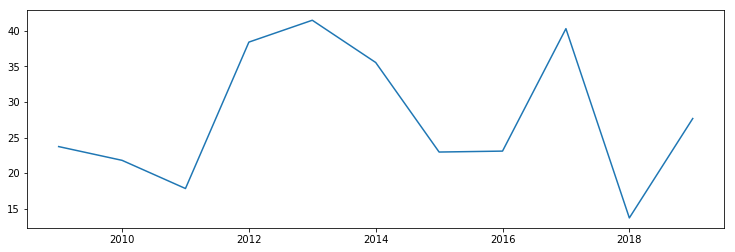

In [175]:
plt.figure(figsize=(12.5,4))
if cons:
    print('conservative')
    x_labels = [2019-i for i in range(12) if i not in cons]
    plt.plot(x_labels, scores)
else:
    plt.plot([2019-i for i in range(11)], scores)
print("")
print("Mean test scores", np.mean(scores))
print("Mean validation scores", np.mean(val_scores))

In [176]:
rows = []
for model in best_models:
    rows.append(model.get_params())
pd.DataFrame(rows).describe()

,base_score,colsample_bylevel,colsample_bynode,colsample_bytree,gamma,learning_rate,max_delta_step,max_depth,min_child_weight,n_estimators,n_jobs,random_state,reg_alpha,reg_lambda,scale_pos_weight,subsample
count,12.0,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.00000,12.000000,12.000000,12.0,12.0,12.000000,12.000000,12.000000,12.000000
mean,0.5,0.348444,0.413921,0.565734,0.059681,0.016249,4.166667,4.25000,4.416667,403.416667,-1.0,0.0,1.455618,1.529966,0.994683,0.357077
std,0.0,0.352759,0.347248,0.317279,0.014835,0.008258,0.717741,1.13818,0.514929,180.838682,0.0,0.0,0.306685,0.393038,0.047225,0.131625
min,0.5,0.100000,0.100000,0.133648,0.040000,0.008588,3.000000,3.00000,4.000000,200.000000,-1.0,0.0,1.000000,1.000000,0.939253,0.138579
25%,0.5,0.100000,0.100000,0.334862,0.048518,0.011201,4.000000,3.00000,4.000000,293.750000,-1.0,0.0,1.302685,1.125044,0.966201,0.256029
50%,0.5,0.152982,0.313394,0.538764,0.059086,0.013844,4.000000,4.00000,4.000000,371.500000,-1.0,0.0,1.366769,1.620694,0.976009,0.391439
75%,0.5,0.487562,0.692299,0.837294,0.071291,0.016896,5.000000,5.00000,5.000000,466.250000,-1.0,0.0,1.629950,1.762589,1.014962,0.459327
max,0.5,1.000000,1.000000,1.000000,0.083480,0.034687,5.000000,6.00000,5.000000,850.000000,-1.0,0.0,2.000000,2.000000,1.090336,0.500000


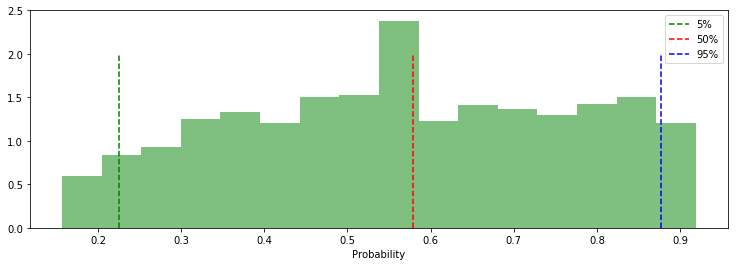

In [177]:
plt.figure(figsize=(12.5,4))
line_height = 2
data = Helpers().averagingModels(X, best_models)
_ = plt.hist(data, bins='auto', density=True, facecolor='green', alpha=0.5)

plt.vlines(np.percentile(data, 5), 0, line_height, linestyle="--", colors='green', label="5%")
plt.vlines(np.percentile(data, 50), 0, line_height, linestyle="--", colors='red', label="50%")
plt.vlines(np.percentile(data, 95), 0, line_height, linestyle="--", colors='blue', label="95%")
plt.xlabel('Probability')
plt.legend()

In [178]:
from helper_functions.functions import Helpers

features = Features().div_cols(X_list[0]).columns

imp = pd.DataFrame(data=Helpers().averagingImp(best_models),
             index=features,
             columns=['importance']).sort_values(by=['importance'], ascending=False)
print(imp.shape)
imp

(22, 1)


,importance
perc,0.068985
F_ph_pa,0.056054
h_M_mean,0.051911
A_ph_pa,0.051188
A_nh_na,0.050635
A_ph_na,0.050106
h_F_mean,0.048673
F_nh_na,0.048594
F_ph_na,0.048232
R_mean,0.047950


## Model Analysis

In [179]:
print(X.shape)
overall = []
for i in range(len(best_models)):
    season_scores = []
    for rnd in range(1,24):
        df = pd.DataFrame(np.c_[X_list[i],y_list[i]])
        y_new = df[df[0] == rnd][X.shape[1]].values
        x_new = df[df[0] == rnd].drop(X.shape[1], axis=1).values
        score = Helpers().afl_loss(y_new,best_models[i].predict_proba(Features().div_cols(x_new).values)[:,1])
        season_scores.append(score)
    overall.append(season_scores)

(2223, 18)


Text(0.5, 1.0, 'Average Cumulative Score')

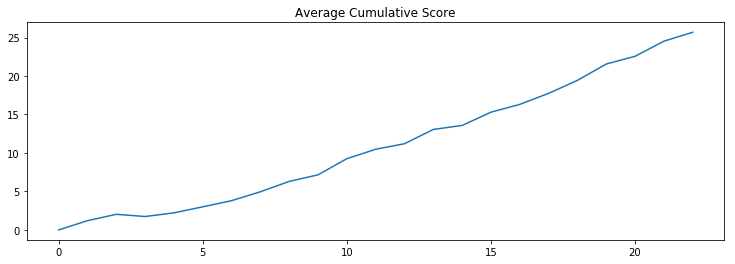

In [180]:
plt.figure(figsize=(12.5,4))
plt.plot(np.cumsum(np.array(np.matrix(np.array(overall)).mean(0)).flatten()))
plt.title('Average Cumulative Score')

In [181]:
if cons:
    data_A = np.load('model_A_scores_cons.npy')
else:    
    data_A = np.load('model_A_scores.npy')
data_B = scores.copy()
print(np.sort(data_A))
print(np.sort(data_B))
print(np.mean(data_A))
print(np.mean(data_B))

[14.38448882 17.35804333 20.98413516 23.16815276 23.40777682 26.35103317
 27.01713176 35.11992385 40.5567424  41.69870561 41.96587788]
[13.71607248 17.8416744  21.79739505 22.96226006 23.09242433 23.72878591
 27.6666786  35.5293022  38.39079745 40.27832761 41.45995419]
28.36472832426896
27.86033384366348


In [182]:
import pymc3 as pm
# The parameters are the bounds of the Uniform.
with pm.Model() as model:
    alpha_A = pm.Exponential('alpha_A', 1/10)
    beta_A = pm.Uniform('beta_A', lower=0, upper=1)
    alpha_B = pm.Exponential('alpha_B', 1/10)
    beta_B = pm.Uniform('beta_B', lower=0, upper=1)
    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", alpha_A/beta_A - alpha_B/beta_B)
    
    obs_A = pm.Gamma("obs_A", alpha=alpha_A, beta=beta_A, observed=data_A)
    obs_B = pm.Gamma("obs_B", alpha=alpha_B, beta=beta_B, observed=data_B)
    
    step = pm.Metropolis()
    trace = pm.sample(18000, step=step)
    burned_trace = trace[1000:]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta_B]
>Metropolis: [alpha_B]
>Metropolis: [beta_A]
>Metropolis: [alpha_A]
Sampling 4 chains: 100%|██████████| 74000/74000 [00:14<00:00, 5166.10draws/s]
The number of effective samples is smaller than 10% for some parameters.


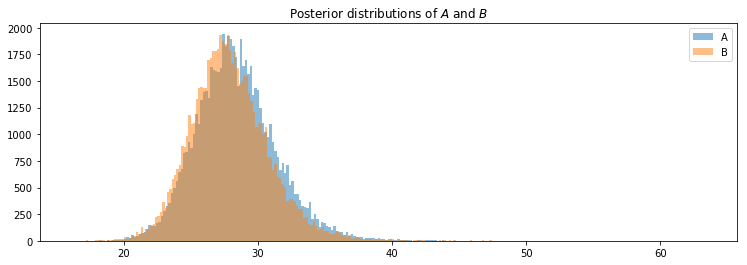

In [183]:
plt.figure(figsize=(12.5,4))
plt.title("Posterior distributions of $A$ and $B$")
plt.hist(burned_trace["alpha_A"]/burned_trace["beta_A"], bins='auto', histtype="stepfilled", alpha=0.5, label="A")
plt.hist(burned_trace["alpha_B"]/burned_trace["beta_B"], bins='auto', histtype="stepfilled", alpha=0.5, label="B")
plt.legend()

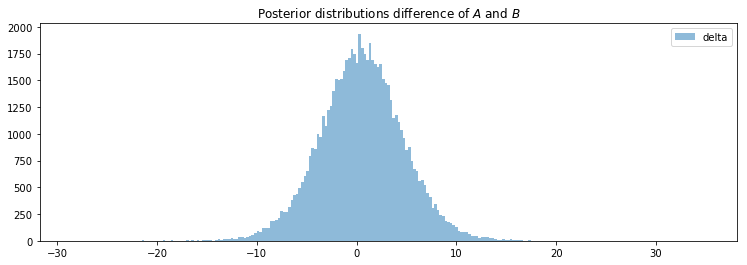

In [184]:
plt.figure(figsize=(12.5,4))
plt.title("Posterior distributions difference of $A$ and $B$")
plt.hist(burned_trace["delta"], bins='auto', histtype="stepfilled", alpha=0.5, label="delta")
plt.legend()

In [185]:
print("Probability model A is WORSE than model B: %.3f" % \
    np.mean(burned_trace["delta"] < 0))

print("Probability model A is BETTER than model B: %.3f" % \
    np.mean(burned_trace["delta"] > 0))

Probability model A is WORSE than model B: 0.451
Probability model A is BETTER than model B: 0.549


In [100]:
# if cons:
#     np.save('model_A_scores_cons.npy', data_B)
# else:
#     np.save('model_A_scores.npy', data_B)

## Save models

In [101]:
from joblib import dump
if cons:
    for i in range(len(best_models)):
        dump(best_models[i], 'models/model_cons'+str(i)+'.joblib') 
else:
    for i in range(len(best_models)):
        dump(best_models[i], 'models/model'+str(i)+'.joblib') 


## Load models

In [190]:
from joblib import load
# model = load('models2/model.joblib')
best_models = []
# for i in range(12):
#     best_models.append(load('models/model'+str(i)+'.joblib'))
for i in range(8):
    best_models.append(load('models/model_cons'+str(i)+'.joblib'))

## Scoring

In [12]:
from data_prep.web_scraping import Scrape

games = []
start = 203
for i in range(start,start+9):
    games.append(Scrape(mapping, proxyDict).scrape_game(i))
games

[['West Coast', 'Collingwood'],
 ['Sydney', 'Carlton'],
 ['Hawthorn', 'Fremantle'],
 ['Essendon', 'North Melbourne'],
 ['Gold Coast', 'Adelaide'],
 ['Geelong', 'St Kilda'],
 ['Richmond', 'Greater Western Sydney'],
 ['Western Bulldogs', 'Melbourne'],
 ['Port Adelaide', 'Brisbane Lions']]

In [41]:
from modelling.scoring import Scoring
scoring_df = Scoring(mapping, proxyDict, enc).score_data(games)
scoring = scoring_df.values

In [42]:
scoring_df

,Rnd,h_F_mean,h_A_mean,h_M_mean,h_R_mean,h_perc,a_F_mean,a_A_mean,a_M_mean,a_R_mean,a_perc,grnd,perc,R_mean,F_ph_na,F_ph_pa,F_nh_na,F_nh_pa,A_nh_pa,A_nh_na,A_ph_pa,A_ph_na
0,17.0,85.000000,74.333333,10.666667,0.733333,1.143498,85.733333,72.466667,13.266667,0.666667,1.183073,23.0,0.966549,1.100000,1.717203,1.005815,0.966915,0.566350,0.640764,0.847479,1.160553,1.534957
1,17.0,78.133333,81.733333,-3.600000,0.400000,0.955954,73.000000,89.266667,-16.266667,0.200000,0.817774,23.0,1.168971,2.000000,1.728927,0.990590,1.209476,0.692970,0.583768,0.979547,0.877504,1.472427
2,17.0,76.066667,78.066667,-2.000000,0.400000,0.974381,74.800000,76.000000,-1.200000,0.466667,0.984211,29.0,0.990013,0.857143,1.812529,0.847870,1.378350,0.644768,0.614161,1.006929,1.039552,1.704367
3,17.0,77.466667,75.866667,1.600000,0.533333,1.021090,84.266667,84.400000,-0.133333,0.466667,0.998420,3.0,1.022705,1.142857,1.576680,0.983961,0.815698,0.509054,0.502018,0.926212,0.884088,1.631122
4,17.0,61.133333,91.133333,-30.000000,0.200000,0.670812,78.866667,75.133333,3.733333,0.533333,1.049689,0.0,0.639058,0.375000,1.225192,0.729309,0.852155,0.507254,0.694190,1.167885,1.239744,2.085709
5,17.0,93.266667,66.333333,26.933333,0.800000,1.406030,72.933333,90.333333,-17.400000,0.400000,0.807380,3.0,1.741472,2.000000,1.781281,1.417976,1.103950,0.878792,0.447419,0.777782,0.709314,1.233056
6,17.0,84.200000,81.733333,2.466667,0.600000,1.030179,91.800000,73.200000,18.600000,0.600000,1.254098,47.0,0.821450,1.000000,1.759152,0.916326,0.918912,0.478653,0.626203,1.068378,1.144825,1.953211
7,17.0,80.066667,85.266667,-5.200000,0.466667,0.939015,73.466667,92.000000,-18.533333,0.333333,0.798551,23.0,1.175899,1.400000,1.791611,1.011247,1.229073,0.693731,0.531700,0.796620,1.013707,1.518788
8,17.0,82.800000,75.066667,7.733333,0.533333,1.103020,90.733333,81.400000,9.333333,0.666667,1.114660,47.0,0.989557,0.800000,1.450018,0.964104,0.835048,0.555216,0.550406,0.862592,0.960226,1.504860


In [200]:
def modelStats(X, models=[]):
    predictions = np.column_stack([
        model.predict_proba(X)[:,1] for model in models
    ])
    return [np.mean(predictions, axis=1), np.median(predictions, axis=1), np.std(predictions, axis=1), 
            np.max(predictions, axis=1), np.min(predictions, axis=1)]

arr = np.c_[ games, best_models[0].predict_proba(scoring)[:,1], modelStats(scoring,best_models)[0],
           modelStats(scoring,best_models)[1],modelStats(scoring,best_models)[2],
            modelStats(scoring,best_models)[3], modelStats(scoring,best_models)[4]] 
df = pd.DataFrame(arr,columns=['home','away', 'prob','prob_avg', 'prob_med', 'prob_std', 'prob_max', 'prob_min'])
df['Home_Win_Score'] = 1 + np.log2(df['prob_avg'].astype(float))
df['Away_Win_Score'] = 1 + np.log2(1-df['prob_avg'].astype(float))

df['correct'] = df[['Home_Win_Score', 'Away_Win_Score']].max(axis=1)
df['incorrect'] = df[['Home_Win_Score', 'Away_Win_Score']].min(axis=1)
df

,home,away,prob,prob_avg,prob_med,prob_std,prob_max,prob_min,Home_Win_Score,Away_Win_Score,correct,incorrect
0,West Coast,Collingwood,0.5673491,0.5973042,0.60074747,0.029062942,0.6316635,0.55197304,0.256538,-0.312238,0.256538,-0.312238
1,Sydney,Carlton,0.67962015,0.6734561,0.6727828,0.02012798,0.7085784,0.6409281,0.429656,-0.614651,0.429656,-0.614651
2,Hawthorn,Fremantle,0.5074515,0.53243834,0.53262174,0.019895907,0.5566385,0.5010757,0.090686,-0.096771,0.090686,-0.096771
3,Essendon,North Melbourne,0.6053911,0.6013,0.6047431,0.017532991,0.61999464,0.56669366,0.266157,-0.326624,0.266157,-0.326624
4,Gold Coast,Adelaide,0.28822353,0.278887,0.27473575,0.011160904,0.29606336,0.26482576,-0.842247,0.528297,0.528297,-0.842247
5,Geelong,St Kilda,0.7972396,0.80129755,0.80612856,0.023121824,0.8307535,0.75891733,0.680410,-1.331318,0.680410,-1.331318
6,Richmond,Greater Western Sydney,0.48558915,0.5130112,0.50697196,0.024116546,0.5648617,0.48558915,0.037062,-0.038040,0.037062,-0.038040
7,Western Bulldogs,Melbourne,0.6917984,0.7126965,0.7158977,0.0186746,0.7426253,0.68794155,0.511360,-0.799353,0.511360,-0.799353
8,Port Adelaide,Brisbane Lions,0.5928901,0.603343,0.59888077,0.02329028,0.63995194,0.5767832,0.271050,-0.334036,0.271050,-0.334036


In [202]:
result_so_far = [0,0,1,1,0,1]
score_so_far = []
for i in range(len(result_so_far)):
    if result_so_far[i] > 0:
        score_so_far.append(df['Home_Win_Score'][i])
    else: 
        score_so_far.append(df['Away_Win_Score'][i])
print('Best case for the round', np.sum(df['correct']))
print('Worst case for the round', np.sum(df['incorrect']))
print('Scores so far for the round',score_so_far)
print('Total so far for the round',np.sum(score_so_far))

Best case for the round 3.0712163218242523
Worst case for the round -4.695278713271957
Scores so far for the round [-0.3122376694146465, -0.6146511366383935, 0.09068636617522208, 0.26615686364661817, 0.5282972557934379, 0.6804099707145245]
Total so far for the round 0.6386616502767626
